<a href="https://colab.research.google.com/github/Pranav2092/Pytorch-Practice/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# Convert mnist image files into tensors of 4-dimensions(# of image, height, width, color channels)
transform = transforms.ToTensor()

In [48]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', train = True, download = True, transform = transform)

In [49]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train = False, download = True, transform = transform)

In [50]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [51]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [52]:
# create a small batch size for image
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [53]:
# Define our CNN model
#Describe convolutional layers and what its doing (2cnn layers)
# this is just an example in next video we'll build out the actual model
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [54]:
# grab 1 minist record/image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [55]:
X_Train.shape

torch.Size([1, 28, 28])

In [56]:
x = X_Train.view(1,1,28,28)

In [57]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified linear unit as our activation function



In [58]:
# 1 single image, 6 no of filter, 26x26 image size
x.shape

torch.Size([1, 6, 26, 26])

In [59]:
# pass thru pooling layer
x = F.max_pool2d(x,2,2) #kernel of 2 and stride of 2

In [60]:
x.shape # 26/ 2 = 13

torch.Size([1, 6, 13, 13])

In [61]:
# Perform our second convolution
x = F.relu(conv2(x)) # Rectified linear unit as our activation function
x.shape # Again we didnt set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [62]:
# pass thru pooling layer
x = F.max_pool2d(x,2,2) #kernel of 2 and stride of 2
x.shape # 11/2 = 5.5 but we have to round down, bcoz we cant invent data to round up

torch.Size([1, 16, 5, 5])

In [63]:
#Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #fully connected layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) # 2x2 kernel and stride 2
    #second pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    # Re-view to flatten in out
    x = x.view(-1,5*5*16) # -1 so that we can vary the batch size
    # Fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x,dim=1)

In [64]:
# Create an instance
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [65]:
# Loss fxn and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)# smaller the learning rate the longer its gonna take to train

In [66]:
import time
start_time = time.time()

# Create vars to track things
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  # Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2d.
    loss = criterion(y_pred,y_train) # how off are we? Compare the predictions to correct answers in y_train
    predicted = torch.max(y_pred.data,1)[1] # get the index, add up the no. of correct predictions. Indexex off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. true = 1, false = 0,sum those up
    trn_corr += batch_corr #keep track as we go along in training
    # Update our params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out some results
    if b%600 == 0:
      print(f"Epoch: {i}, Batch: {b}, Loss: {loss.item()}")
  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test
  with torch.no_grad(): # no gradient so we dont update our weights ans biases with our test data
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()
  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f"Training took: {total/60} minutes")

Epoch: 0, Batch: 600, Loss: 0.16236107051372528
Epoch: 0, Batch: 1200, Loss: 0.15510495007038116
Epoch: 0, Batch: 1800, Loss: 0.4651116728782654
Epoch: 0, Batch: 2400, Loss: 0.17726822197437286
Epoch: 0, Batch: 3000, Loss: 0.007429888937622309
Epoch: 0, Batch: 3600, Loss: 0.37731707096099854
Epoch: 0, Batch: 4200, Loss: 0.004938055761158466
Epoch: 0, Batch: 4800, Loss: 0.0015040982980281115
Epoch: 0, Batch: 5400, Loss: 0.06845302879810333
Epoch: 0, Batch: 6000, Loss: 0.0004587689763866365
Epoch: 1, Batch: 600, Loss: 0.002925408538430929
Epoch: 1, Batch: 1200, Loss: 0.2792360186576843
Epoch: 1, Batch: 1800, Loss: 0.0018853390356525779
Epoch: 1, Batch: 2400, Loss: 0.0030733426101505756
Epoch: 1, Batch: 3000, Loss: 0.024190708994865417
Epoch: 1, Batch: 3600, Loss: 0.5062173008918762
Epoch: 1, Batch: 4200, Loss: 0.02014169655740261
Epoch: 1, Batch: 4800, Loss: 0.001421573688276112
Epoch: 1, Batch: 5400, Loss: 0.0006034405087120831
Epoch: 1, Batch: 6000, Loss: 0.1528162956237793
Epoch: 2, B

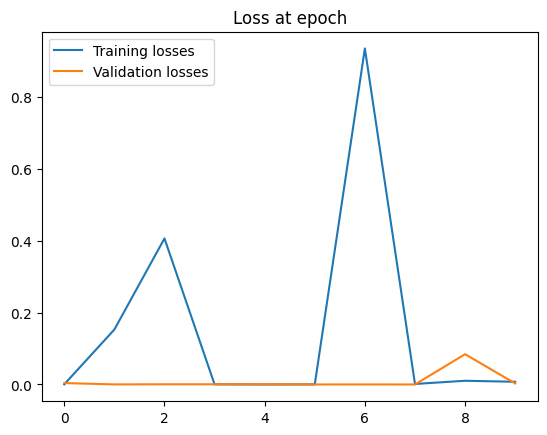

In [67]:
#Graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]
plt.plot(train_losses,label="Training losses")
plt.plot(test_losses,label="Validation losses")
plt.title("Loss at epoch")
plt.legend()

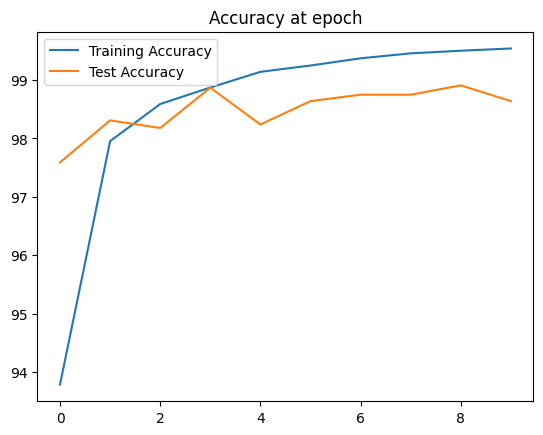

In [69]:
# Graph the accuracy at the end of epoch
plt.plot([t/600 for t in train_correct],label="Training Accuracy")
plt.plot([t/100 for t in test_correct],label="Test Accuracy")
plt.title("Accuracy at epoch")
plt.legend()

In [70]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [72]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
  print(f"Accuracy on test data: {correct/100}")

Accuracy on test data: 98.63999938964844


In [73]:
torch.save(model.state_dict(), 'mnist_cnn.pt')

In [82]:
test_data[1978] # Tensor with an integer in it ... at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [83]:
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [84]:
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

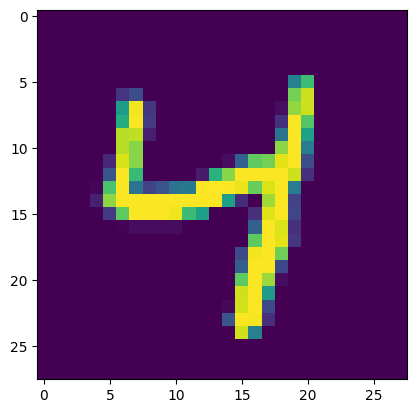

In [85]:
plt.imshow(test_data[1978][0].reshape(28,28))
plt.show()

In [86]:
model.eval()
with torch.no_grad():
  test_prediction = model(test_data[1978][0].view(1,1,28,28))

In [87]:
test_prediction

tensor([[-2.2000e+01, -1.2139e+01, -1.9474e+01, -2.3467e+01, -3.2789e-04,
         -1.2204e+01, -8.0598e+00, -2.0677e+01, -2.1231e+01, -1.3488e+01]])

In [88]:
test_prediction.argmax()

tensor(4)